In [13]:
import glob
import numpy as np
import pandas as pd
import os
import time
import math
import numpy as np
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
from torch import optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split
import sys
sys.path.append('..')

from word_cnn.model import TCN
from MIDI.PRETTY_MIDI.pretty_midi_tokenization import PrettyMidiTokenizer, BCI_TOKENS

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',504)
pd.set_option('display.width',1000)


DIRECTORY_PATH = ''


# MODEL PARAMETERS
EPOCHS = 500 # 500
LEARNING_RATE = 2 # 4
BATCH_SIZE = 16 # 16
TRAIN_MODEL = True
FEEDBACK = True


In [6]:
'''
Assumptions:
Sequences described as input_#.mid and output_#.mid in the corresponding folders
'''
DATASET_PATH = os.path.join(DIRECTORY_PATH, 'dataset')

input_filenames = glob.glob(os.path.join(DATASET_PATH, 'input/*.MID'))
print('Number of input files:', len(input_filenames))

output_filenames = glob.glob(os.path.join(DATASET_PATH, 'output/*.MID'))
print('Number of output files:', len(output_filenames), '\n')

INPUT_TOK = PrettyMidiTokenizer()
OUTPUT_TOK = PrettyMidiTokenizer()

for i, (in_file, out_file) in enumerate(zip(input_filenames, output_filenames)):

    in_file_name = os.path.basename(in_file)
    out_file_name = os.path.basename(out_file)
    print(f'{i + 1}: {in_file_name} -> {out_file_name}')

    if 'RELAX' in in_file_name:
        emotion_token = BCI_TOKENS['relax']
    elif 'EXCITED' in in_file_name:
        emotion_token = BCI_TOKENS['concentrate']
    else:
        raise Exception('Emotion not found in file name. Please add the emotion to the file name.')

    in_seq, in_df = INPUT_TOK.midi_to_tokens(in_file, update_vocab=True, update_sequences=True, emotion_token = emotion_token)
    out_seq, out_df = OUTPUT_TOK.midi_to_tokens(out_file, update_vocab=True, update_sequences=True)

    print(f'Input sequence length: {len(in_seq)}')
    print(f'Emotion token: {emotion_token}\n')

print(f'\nNumber of input sequences: {len(INPUT_TOK.sequences)}')
print(f'Input sequence length: {len(INPUT_TOK.sequences[0])}')
print(f'Input vocabulars size: {len(INPUT_TOK.VOCAB)}')
print(f'\nNumber of output sequences: {len(OUTPUT_TOK.sequences)}')
print(f'Output sequence length: {len(OUTPUT_TOK.sequences[0])}')
print(f'Output vocabulars size: {len(OUTPUT_TOK.VOCAB)}')

print('\nInput vocab:', INPUT_TOK.VOCAB.word2idx)
print('Output vocab:', OUTPUT_TOK.VOCAB.word2idx)
    

Number of input files: 6
Number of output files: 6 

1: 0_Drum_HardRock_EXCITED.mid -> 0_Bass_HardRock_EXCITED.mid
Input sequence length: 26
Emotion token: C

2: 1_Drum_HardRock_RELAX.mid -> 1_Bass_HardRock_RELAX.mid
Input sequence length: 32
Emotion token: R

3: 2_Drum_Blues_EXCITED.mid -> 2_Bass_Blues_EXCITED.mid
Input sequence length: 31
Emotion token: C

4: 3_Drum_Blues_RELAX.mid -> 3_Bass_Blues_RELAX.mid
Input sequence length: 23
Emotion token: R

5: 4_Drum_PopRock_EXCITED.mid -> 4_Bass_PopRock_EXCITED.mid
Input sequence length: 35
Emotion token: C

6: 5_Drum_PopRock_RELAX.mid -> 5_Bass_PopRock_RELAX.mid
Input sequence length: 23
Emotion token: R


Number of input sequences: 170
Input sequence length: 192
Input vocabulars size: 92

Number of output sequences: 170
Output sequence length: 192
Output vocabulars size: 95

Input vocab: {'O': 0, '36fS': 1, '36f': 2, '36f_42pS': 3, '38fS': 4, '38f': 5, '38f_42pS': 6, '42fS_36fS': 7, '42fS_38fS': 8, '38f_42fS': 9, '38f_42f': 10, '36f_42pS

In [14]:
# Create the dataset
dataset = TensorDataset(torch.LongTensor(INPUT_TOK.sequences).to(device),
                        torch.LongTensor(OUTPUT_TOK.sequences).to(device))

# Split the dataset into training, evaluation and test sets
train_set, eval_set, test_set = random_split(dataset, [0.6, 0.2, 0.2])

# Create the dataloaders
train_sampler = RandomSampler(train_set)          
train_dataloader = DataLoader(train_set, sampler=train_sampler, batch_size=BATCH_SIZE)

eval_sampler = RandomSampler(eval_set)
eval_dataloader = DataLoader(eval_set, sampler=eval_sampler, batch_size=BATCH_SIZE)

test_sampler = RandomSampler(test_set)
test_dataloader = DataLoader(test_set, sampler=test_sampler, batch_size=BATCH_SIZE)

print(f'Train set size: {len(train_set)}')
print(f'Evaluation set size: {len(eval_set)}')
print(f'Test set size: {len(test_set)}')


Train set size: 102
Evaluation set size: 34
Test set size: 34


In [32]:
# Set the hyperparameters
SEED = 1111
OUTPUT_SIZE = len(OUTPUT_TOK.VOCAB) 


'''
IMPORTANT:
to cover all the sequence of tokens k * d must be >= hidden units (see the paper)
k = kernel_size
d = dilation = 2 ^ (n_levels - 1) 
'''
if FEEDBACK:
    INPUT_SIZE = len(INPUT_TOK.VOCAB) + OUTPUT_SIZE
    LEVELS = 8
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH * 2 # 192 * 2 = 384
else:
    INPUT_SIZE = len(INPUT_TOK.VOCAB) 
    LEVELS = 7
    HIDDEN_UNITS = INPUT_TOK.SEQ_LENGTH # 192 


EMBEDDING_SIZE = 20 # size of word embeddings -> Embedding() is used to encode input token into [192, 20] real value vectors (see model.py)
NUM_CHANNELS = [HIDDEN_UNITS] * (LEVELS - 1) + [EMBEDDING_SIZE] # [192, 192, 192, 192, 192, 192, 20]
GRADIENT_CLIP = 0.35


# balance the loss function by assigning a weight to each token related to its frequency
LOSS_WEIGTHS = torch.ones([OUTPUT_SIZE], dtype=torch.float)
OUTPUT_TOK.VOCAB.compute_weights()
for i, weigth in enumerate(OUTPUT_TOK.VOCAB.weights):
    LOSS_WEIGTHS[i] = 1 - weigth
    # print(f'{OUTPUT_TOK.VOCAB.idx2word[i]}: {LOSS_WEIGTHS[i]}')


# create the model
model = TCN(input_size = INPUT_SIZE,
            embedding_size = EMBEDDING_SIZE, 
            output_size = OUTPUT_SIZE, 
            num_channels = NUM_CHANNELS, 
            dropout = 0.45, 
            emb_dropout = 0.25, 
            kernel_size = 3, 
            tied_weights = False) # tie encoder and decoder weights (legare)

model.to(device)

# May use adaptive softmax to speed up training
torch.manual_seed(SEED)
criterion = nn.CrossEntropyLoss(weight = LOSS_WEIGTHS)
optimizer = getattr(optim, 'SGD')(model.parameters(), lr=LEARNING_RATE)

print(f'\nModel created: {model}')



Model created: TCN(
  (encoder): Embedding(187, 20)
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(20, 384, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.45, inplace=False)
        (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.45, inplace=False)
        (net): Sequential(
          (0): Conv1d(20, 384, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.45, inplace=False)
          (4): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.45, inplace=False)
        )
        (downsample): Conv1d(20, 384, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
   

In [67]:
BAR_LENGTH = INPUT_TOK.BAR_LENGTH

def epoch_step(dataloader, mode):

    if FEEDBACK:
        prev_output = torch.zeros([BATCH_SIZE, INPUT_TOK.SEQ_LENGTH], dtype=torch.long, device=device)

    if mode == 'train':
        model.train()
    else:
        model.eval() # disable dropout
        
    total_loss = 0

    # iterate over the training data
    for batch_idx, (data, targets) in enumerate(dataloader):

        batch_idx += 1

        # mask the last bar of the input data
        batch_size = data.size(0)
        data_masked = torch.cat((data[:, :BAR_LENGTH*3], torch.ones([batch_size, BAR_LENGTH], dtype=torch.long)), dim = 1) 

        if FEEDBACK:
            input = torch.cat((data_masked, prev_output[:batch_size, :]), dim = 1)
        else:
            input = data_masked
           
        # reset model gradients to zero
        optimizer.zero_grad()

        # make the prediction
        output = model(input)
        prev_output = torch.argmax(output, 2)# batch, seq_len (hidden units), vocab_size
        prev_output = prev_output[:, :INPUT_TOK.SEQ_LENGTH] 

        # flatten the output sequence
        # NB: the size -1 is inferred from other dimensions
        # NB: contiguous() is used to make sure the tensor is stored in a contiguous chunk of memory, necessary for view() to work
    
        if FEEDBACK:
            final_target = torch.cat((targets.contiguous().view(-1),targets.contiguous().view(-1)))
        else:
            final_target = targets.contiguous().view(-1)
            
        final_output = output.contiguous().view(-1, OUTPUT_SIZE)

        # calculate the loss
        loss = criterion(final_output, final_target)

        if mode == 'train':
            # calculate the gradients
            loss.backward()

            # clip the gradients to avoid exploding gradients
            if GRADIENT_CLIP > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP)

            # update the weights
            optimizer.step()

        total_loss += loss.data.item()

    return total_loss / len(dataloader)


In [68]:
best_eval_loss = 1e8
best_train_loss = 1e8
best_model_epoch = 0
eval_losses = []
train_losses = []
lr = LEARNING_RATE
early_stop = False


if TRAIN_MODEL:

    RESULTS_PATH = os.path.join(DIRECTORY_PATH, 'results', time.strftime("%Y%m%d_%H%M%S"))
    if not os.path.exists(RESULTS_PATH):
        os.makedirs(RESULTS_PATH)
        
    MODEL_PATH = os.path.join(RESULTS_PATH, 'model_state_dict.pth')

    
    for epoch in range(1, EPOCHS+1):

        start_time = time.time()

        train_loss = epoch_step(train_dataloader, 'train')
        
        eval_loss = epoch_step(eval_dataloader, 'eval')

        # Save the model if the validation loss is the best we've seen so far.
        if eval_loss < best_eval_loss:
            torch.save(model.state_dict(), MODEL_PATH)
            best_eval_loss = eval_loss
            best_model_epoch = epoch 

        if train_loss < best_train_loss:
            best_train_loss = train_loss

        # # Anneal the learning rate if the validation loss plateaus
        # if epoch > 5 and eval_loss >= max(eval_losses[-5:]):
        #     lr = lr / 2.
        #     if lr < 0.1:
        #         lr = 2
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = lr


        eval_losses.append(eval_loss)
        train_losses.append(train_loss)

        # Early stopping
        if epoch > 15:
            if min(eval_losses[-15:]) > best_eval_loss:
                break

        # print the loss and the progress
        elapsed = time.time() - start_time
        print('| epoch {:3d}/{:3d} | lr {:02.5f} | ms/epoch {:5.5f} | train_loss {:5.2f} | eval_loss {:5.2f}' \
                .format(epoch, EPOCHS, lr, elapsed * 1000, train_loss, eval_loss))

    print('\n\n TRAINING FINISHED:\n\n\tBest Loss: {:5.2f}\tBest Model saved at epoch: {:3d}' \
            .format(best_eval_loss, best_model_epoch))

| epoch   1/500 | lr 2.00000 | ms/epoch 24148.30327 | train_loss  3.51 | eval_loss  3.59
| epoch   2/500 | lr 2.00000 | ms/epoch 29405.52521 | train_loss  3.50 | eval_loss  3.56
| epoch   3/500 | lr 2.00000 | ms/epoch 26099.39575 | train_loss  3.50 | eval_loss  3.56
| epoch   4/500 | lr 2.00000 | ms/epoch 25321.39730 | train_loss  3.49 | eval_loss  3.56
| epoch   5/500 | lr 2.00000 | ms/epoch 26021.42453 | train_loss  3.49 | eval_loss  3.57
| epoch   6/500 | lr 2.00000 | ms/epoch 27082.67784 | train_loss  3.50 | eval_loss  3.57
| epoch   7/500 | lr 2.00000 | ms/epoch 24548.33412 | train_loss  3.48 | eval_loss  3.55
| epoch   8/500 | lr 2.00000 | ms/epoch 24559.70454 | train_loss  3.47 | eval_loss  3.55
| epoch   9/500 | lr 2.00000 | ms/epoch 24464.55622 | train_loss  3.48 | eval_loss  3.57
| epoch  10/500 | lr 2.00000 | ms/epoch 29560.15301 | train_loss  3.48 | eval_loss  3.60
| epoch  11/500 | lr 2.00000 | ms/epoch 26954.83828 | train_loss  3.49 | eval_loss  3.57
| epoch  12/500 | lr 

KeyboardInterrupt: 

In [34]:
# test the model
test_loss = epoch_step(test_dataloader, 'eval')
print(f'\n\nTEST LOSS: {test_loss}')



TEST LOSS: 0.08584819696843624


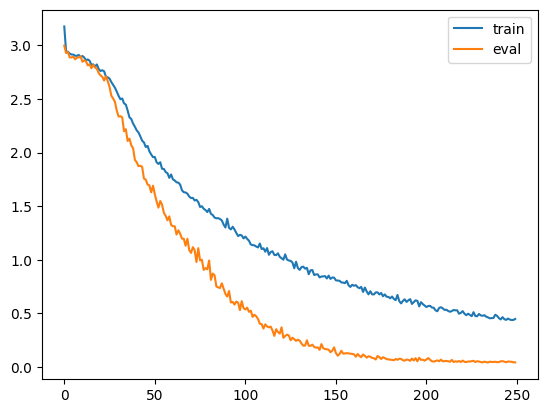

In [36]:
if TRAIN_MODEL:
    # plot the losses over the epochs 
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.legend()
    plt.savefig(os.path.join(RESULTS_PATH, 'losses.png'))

    plt.show()


    # save the vocabularies
    INPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'input_vocab.txt'))
    OUTPUT_TOK.VOCAB.save(os.path.join(RESULTS_PATH, 'output_vocab.txt'))

     # save the model hyperparameters in a file txt
    with open(os.path.join(RESULTS_PATH, 'model_hyperparameters.txt'), 'w') as f:

        f.write(f'----------OPTIMIZATION PARAMETERS----------\n')
        f.write(f'DATE: {time.strftime("%Y%m%d-%H%M%S")}\n')
        f.write(f'DATASET_PATH: {DATASET_PATH}\n')
        f.write(f'FEEDBACK: {FEEDBACK}\n')
        f.write(f'SEED: {SEED}\n')
        f.write(f'INPUT_SIZE: {INPUT_SIZE}\n')
        f.write(f'EMBEDDING_SIZE: {EMBEDDING_SIZE}\n')
        f.write(f'LEVELS: {LEVELS}\n')
        f.write(f'HIDDEN_UNITS: {HIDDEN_UNITS}\n')
        f.write(f'NUM_CHANNELS: {NUM_CHANNELS}\n')
        f.write(f'OUTPUT_SIZE: {OUTPUT_SIZE}\n')
        f.write(f'LOSS_WEIGTHS: {LOSS_WEIGTHS}\n')
        f.write(f'LEARNING_RATE: {LEARNING_RATE}\n')
        f.write(f'BATCH_SIZE: {BATCH_SIZE}\n')
        f.write(f'EPOCHS: {EPOCHS}\n')
        f.write(f'GRADIENT_CLIP: {GRADIENT_CLIP}\n')
        f.write(f'------------------------------------------\n')
        f.write(f'----------RESULTS----------\n')
        f.write(f'TRAIN_LOSSES: {train_losses}\n')
        f.write(f'BEST_EVAL_LOSS: {best_train_loss}\n')
        f.write(f'TEST_LOSS: {test_loss}\n')
        f.write(f'BEST_MODEL_EPOCH: {best_model_epoch}\n')
        f.write(f'------------------------------------------\n')

In [16]:
# Load the best saved model.
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

# select a genere to be predicted
generes = ['blues', 'rock_excited', 'rock_relax']

for genere in generes:
    # get a sample to be predicted
    sample_path = os.path.join(DATASET_PATH, f'test/drum_{genere}.mid')
    sample = INPUT_TOK.midi_to_tokens(sample_path, update_vocab=False) [0]
    print(sample[0])
    sample = torch.LongTensor(sample).to(device)

    # Get the last sequence from the batch and unsqueeze it to add a batch dimension.
    sample = sample[-1].unsqueeze(0)

    # Mask the last bar of the input data.
    sample = torch.cat((sample[:, :BAR_LENGTH*3], torch.ones([1, BAR_LENGTH], dtype=torch.long)), dim = 1)

    # Make the prediction.
    prediction = model(sample)
    prediction = prediction.contiguous().view(-1, OUTPUT_SIZE)

    # Get the predicted tokens.
    predicted_tokens = torch.argmax(prediction, 1)

    # Get the predicted sequence.
    predicted_sequence = predicted_tokens.cpu().numpy().tolist()

    # Convert the predicted sequence to MIDI.
    out_file_path = os.path.join(RESULTS_PATH, f'predicted_{genere}.mid')
    pitch_ticks_list =  OUTPUT_TOK.tokens_to_midi(predicted_sequence, out_file_path) # midi is a pretty midi object

# check 
predicted_sequence_string = []
for id in predicted_sequence:
    predicted_sequence_string.append(OUTPUT_TOK.VOCAB.idx2word[id])
print(predicted_sequence_string)
print(pitch_ticks_list)

[0 40 41 41 41 41 4 0 0 0 0 0 0 3 4 4 4 4 50 8 8 8 8 8 88 74 74 74 74 74 0
 0 0 0 0 3 4 4 4 4 4 20 7 7 7 7 7 50 40 41 41 41 41 4 0 0 0 0 0 3 4 4 4 4
 4 50 8 8 8 8 8 88 74 74 74 74 74 4 4 0 0 0 0 0 3 4 4 4 4 4 0 0 0 0 0 0 1
 2 2 2 2 2 2 0 0 0 0 0 3 4 4 4 4 4 17 8 8 8 8 8 88 74 74 74 74 74 74 0 0 0
 0 3 4 4 4 4 4 20 6 7 7 7 7 1 1 2 2 2 2 124 125 37 37 37 37 0 1 2 2 2 2 2
 2 0 0 0 0 0 88 74 74 74 74 74 74 0 0 0 0 0 3 4 4 4 4 4 0 0 0 0 0 0]
MIDI file saved at results\20240628-183038\predicted_rock_relax.mid
['43fS', '55fS', '55f', '55f', '55f', '55f', '50f', '50f', '52f', '52f', '52f', '52f', '52f', '52f', '52f', '52f', '57fS', '52f', '55fS', '57f', '57f', '57f', '55f', '55f', '64f', '64f', '64f', '64f', '62f', 'O', '57f', '57f', '57f', '57f', '57f', '50fS', '50f', '50f', '50f', '50f', '50f', '50f', '50f', '50f', '50f', 'O', 'O', '48fS', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', '48f', 'O', '55fS', '55f', '55f', '55f', '55f', '